# SVM 

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import cv2 #!pip install opencv-python
from scipy.optimize import minimize
import librosa                    
import librosa.display


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

#!pip install lightgbm
#import lightgbm as lgbm

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Initial shape: (288, 432)


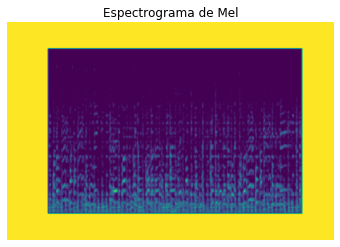

In [2]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
classes = []
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            classes.append(genre)
            genres[genre] = i
            i+=1

print(classes)

img = cv2.imread(img_dataset[0],0)
print("Initial shape:",img.shape)

plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

Para quitar el borde que vemos amarillo y no aporta nada solo cogemos los pixeles que esten dentro del spectograma

In [3]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        #img = crop_borders(img,x1=50,x2=252,y1=54,y2=244)
        x[i] = img.ravel()
    return np.array(x).T

In [4]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    #plt.yticks(tick_marks, genres) #imprime mal en jupyter

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Shape: (217, 335)


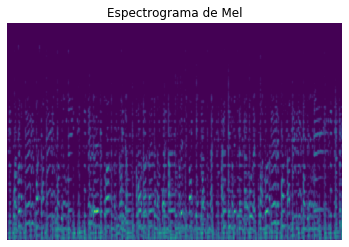

In [5]:
img = cv2.imread(img_dataset[0],0)
img = crop_borders(img)
#img = crop_borders(img,x1=50,x2=252,y1=54,y2=244) #crop to low scale
print("Shape:",img.shape)

plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

In [6]:
X = get_x(shape=[999,img.ravel().shape[0]]).T
y = get_y()

m = len(y)
num_labels = 10 #estilos de musica diferente

print(X.shape, y.shape)

(999, 72695) (999,)


## SVM con Imagen Completa

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72695) (749, 72695) (250, 72695)


In [8]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)#C = 1 and kernel = rbf best results
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  8.0min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [9]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5260
best score on test set (accuracy) = 0.5040


In [10]:
cm = confusion_matrix(y_test, preds)

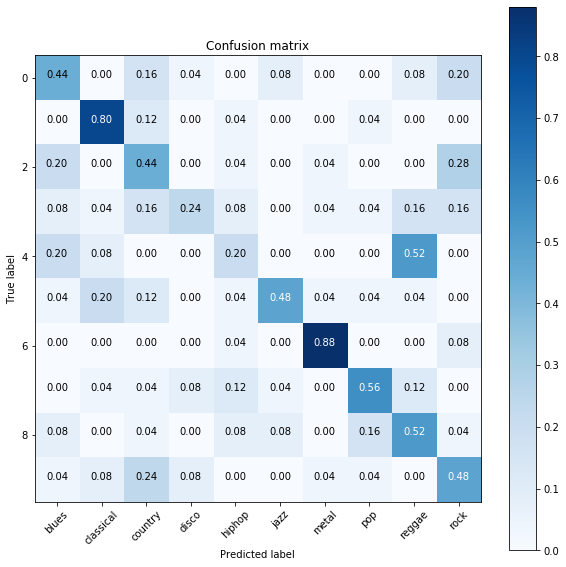

In [11]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [12]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
    
genres_pred

files = os.listdir('./test_songs/images/')
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']

In [13]:
for song in songs:
    img = cv2.imread(song,0)
    mel = img.ravel()
    pred = grid_svm.predict(mel.reshape(1, -1))
    print(song[20:-4],"-->",genres_pred[int(pred)],'\n')

abba --> rock 

desakato --> disco 

elfinde --> hiphop 

iseo --> hiphop 

marley --> pop 

metallica --> blues 

paradise --> hiphop 

requiem --> classical 

sultans --> country 

wutang --> jazz 



Al entrenar con la imagen entera (72695 pixeles en total) tarda bastante mas, unos 20min en encontrar el mejor candidato, que en el conjunto de test da una precision de 50%

## SVM con KAZE

In [14]:
#Extrae caracteristicas de la imagen usando un algoritmo de OpenCV --> KAZE
def extract_features(image_path, vector_size=32):
    image = cv2.imread(image_path, 1)
    image = crop_borders(image)
    try:
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

img_features = extract_features(img_dataset[9])
X_KAZE = np.empty([999,img_features.shape[0]], np.float32)

i = 0
for f in img_dataset:
    if i % 100 == 0:
        print ('Extracting features from folder %s' % f.split('/')[3].split('\\')[0])
    X_KAZE[i] =  extract_features(f)
    i += 1
    
    
X_KAZE.shape

Extracting features from folder blues
Extracting features from folder classical
Extracting features from folder country
Extracting features from folder disco
Extracting features from folder hiphop
Extracting features from folder jazz
Extracting features from folder metal
Extracting features from folder pop
Extracting features from folder reggae
Extracting features from folder rock


(999, 2048)

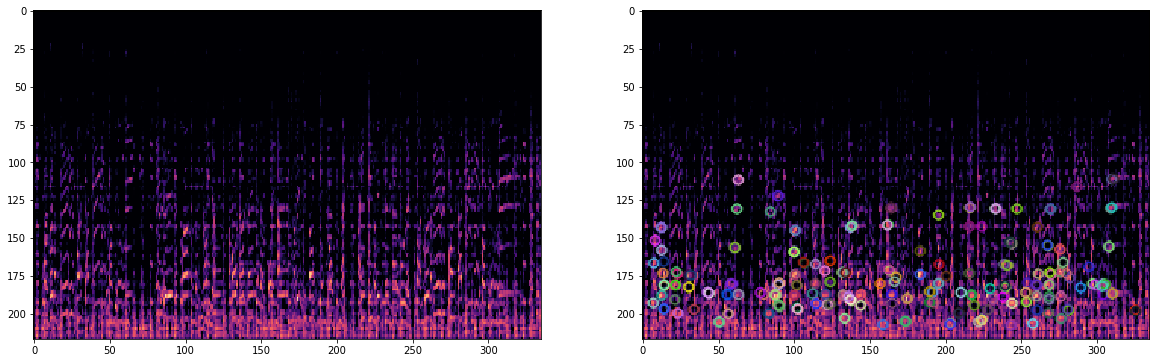

In [15]:
image_path = 'data/images_original/blues/blues00000.png'
image = cv2.imread(image_path, 1)
image = crop_borders(image)
alg = cv2.KAZE_create()
kps = alg.detect(image)

keypoints_img = image
keypoints_img = cv2.drawKeypoints(image,kps, keypoints_img)

fig=plt.figure(figsize=(20,20))

fig.add_subplot(1, 2, 1)
image = cv2.imread(image_path, 1)
image = crop_borders(image)
plt.imshow(image[...,::-1])

fig.add_subplot(1, 2, 2)
plt.imshow(keypoints_img[...,::-1])

plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_KAZE, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72695) (749, 2048) (250, 2048)


In [17]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   12.8s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   13.0s
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [18]:
preds = grid_svm.predict(X_test)
print("best score on validation set with KAZE (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set with KAZE (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set with KAZE (accuracy) = 0.3151
best score on test set with KAZE (accuracy) = 0.3160


In [19]:
cm = confusion_matrix(y_test, preds)

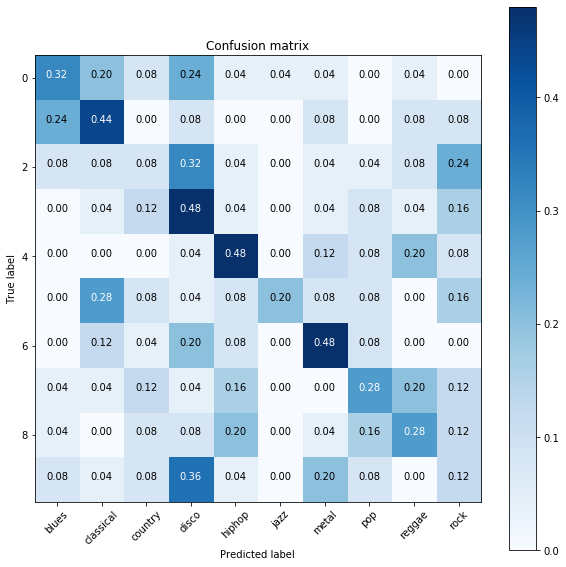

In [20]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [21]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
    
genres_pred

files = os.listdir('./test_songs/images/')
songs = [ './test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']

In [22]:
for song in songs:
    img = extract_features(song)
    mel = img.ravel()
    pred = grid_svm.predict(mel.reshape(1, -1))
    print(song[20:-4],"-->",genres_pred[int(pred)],'\n')

abba --> classical 

desakato --> pop 

elfinde --> metal 

iseo --> hiphop 

marley --> pop 

metallica --> reggae 

paradise --> pop 

requiem --> classical 

sultans --> blues 

wutang --> hiphop 



Con KAZE solo tarda 30s en entrenar dando una precision en test de un 33%
No es muy efectivo usando una SVM, puede que con una CNN esto agilize el proceso y aun asi de buenos resultados

## SVM Caracteristicas de la cancion

In [23]:
df = pd.read_csv('./data/features_30_sec.csv')

df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [24]:
df.loc[df['filename'] == 'jazz.00054.wav'] #Corrupted

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
554,jazz.00054.wav,662112,0.27827,0.083737,0.162394,0.002747,1670.233117,255560.9662,2109.438546,191916.069574,...,44.333191,-5.273277,56.501907,-1.605975,60.76976,-2.93224,52.397224,-1.418922,100.980064,jazz


In [25]:
df1 = df.iloc[:, 1:-1]
X = df1.to_numpy()

In [26]:
X = np.delete(X, 554, axis=0)

In [27]:
print(X.shape) #Solo 58 features por cancion -> pocas

(999, 58)


In [28]:
#Funciones para obtener las caracteristicas de las canciones del dataset
#Obtenemos 133 caracteristicas, mas de el doble que de las que teniamos antes

def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                if(file != "jazz.00054.wav"): #archivo corrupto
                    file_name = folder + "/" + file
                    signal, sr = librosa.load(file_name)

                    # Debug process
                    if debug:
                        print("Reading file: {}".format(file_name))

                    # Append the result to the data structure
                    features = get_features(signal, sr)
                    features['genre'] = genres[x]
                    arr_features.append(features)
    return arr_features

In [29]:
df_features = pd.read_csv('./data/gtzan_features.csv')

In [30]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 133) (749, 133) (250, 133)


In [32]:
params = {
    "cls__C": [0.1, 0.5, 1, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)#C = 1 and kernel = rbf best results
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0998s.) Setting batch_size=4.
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapse

C:\Users\willw\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [33]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7757
best score on test set (accuracy) = 0.7680


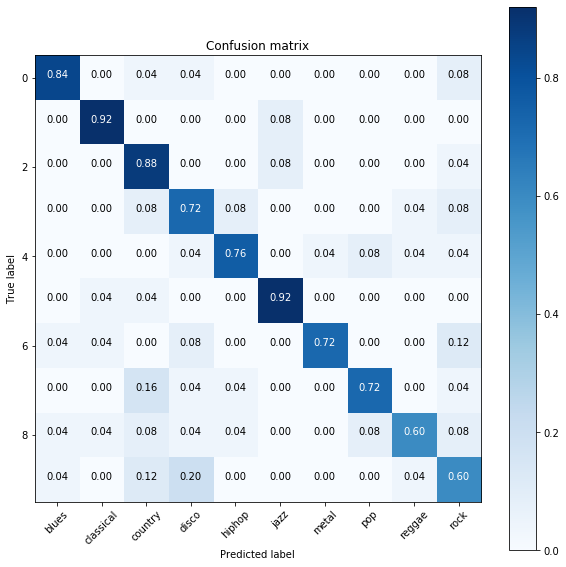

In [34]:
cm = confusion_matrix(y_test,preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

Al entrenar la SVM con las 133 caracteristicas obtenemos la mayor precision de todas, en el conjunto de test un 78%, entrenandola con las 58 obtenemos una precision algo menor de un 72%

In [35]:
arr_features = []

# Read files from the folders
folder = './test_songs/'
files = os.listdir(folder)
files = ['./test_songs/'+img for img in files if img.split('.')[-1] == 'mp3']
for file in files:
    # Read the audio file
    signal, sr = librosa.load(file, duration=30.0)
    print("Reading file: {}".format(file))
    # Append the result to the data structure
    features = get_features(signal, sr)
    arr_features.append(features)

gtzan_dir = './test_songs'
df_features = pd.DataFrame(arr_features)

Reading file: ./test_songs/abba.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/desakato.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/elfinde.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/iseo.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/marley.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/metallica.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/paradise.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/requiem.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/sultans.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


Reading file: ./test_songs/wutang.mp3


C:\Users\willw\Anaconda3\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


In [36]:
X_pruebas = df_features
preds = grid_svm.predict(X_pruebas)

In [37]:
i = 0
for pred in preds:
    print(songs[i][20:-4],"-->",genres_pred[int(pred)],'\n')
    i += 1

abba --> classical 

desakato --> classical 

elfinde --> classical 

iseo --> hiphop 

marley --> classical 

metallica --> metal 

paradise --> classical 

requiem --> classical 

sultans --> rock 

wutang --> hiphop 



In [38]:
from sklearn.externals import joblib
joblib.dump(grid_svm, "./models/svm_features.joblib")

C:\Users\willw\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./models/svm_features.joblib']